In [1]:
from importlib import reload
from pyfvtool import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import root
from tqdm import tqdm
from scipy.interpolate import interp1d

import sys
sys.path.append('..')
from pymadreq import *
import pymadreq.coreflood as cf
import pymadreq.fractional_flow as ff
import pymadreq.IO as IO

reload(ff)
reload(cf)
reload(IO)

<module 'pymadreq.IO' from 'c:\\Users\\aaeft\\Documents\\GitHub\\PyMADREQ\\examples\\..\\pymadreq\\IO.py'>

## Reading input file and defining the domain

In [2]:
# read the input file
data = IO.read_json("../examples/sample.json")
rel_perm_ww, rel_perm_ow, pc_ww, pc_ow = IO.read_transport_functions(data)
core_plug = IO.read_core_properties(data)
fluids = IO.read_fluids(data)
IC = IO.read_initial_conditions(data) # initial conditions
BC = IO.createFloodingCondition(data["BC"]) # boundary conditions
numerical_params = IO.read_numerical_settings(data)
m = IO.read_flooding_domain(data)

## Read the Excel file of the experimental data

In [ ]:
# TODO: add excel reader for updating the model input for optimization

In [3]:
cf_1d = cf.CoreFlooding1D(
    rel_perm_ww, pc_ww, core_plug, fluids, IC, BC, numerical_params, Nx=30
)

cf2d = cf.CoreFlooding2D(
    rel_perm_ww, pc_ww, core_plug, fluids, IC, BC, numerical_params, Nx=20, Nr = 5
)

xt_shock, sw_shock, xt_prf, sw_prf, t_ana, p_inj_ana, R_oil_ana = ff.frac_flow_wf(
    fluids, rel_perm_ww, core_plug, IC, ut=cf_1d.u_inj, sw_inj=1.0, pv_inj=3.0)

c:\Users\aaeft\venvs\myfvm\Lib\site-packages\pyfvtool\cell.py:97: RuntimeWarning: invalid value encountered in divide
  return CellVariable(self.domain, self.value/other.value)


In [4]:
t_data, R_data, dp_data = cf_1d.simulate_no_pc()


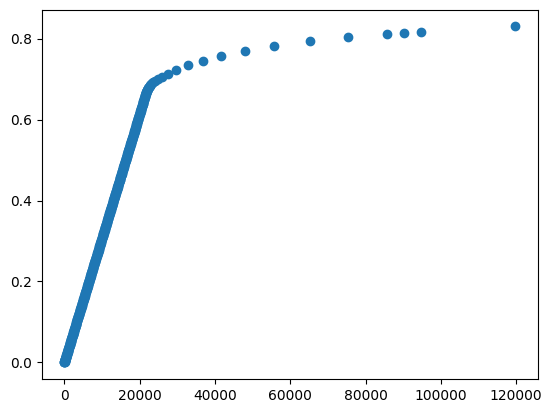

In [5]:
plt.plot(t_data, R_data, 'o')
cf_1d.numerical_params.simulation_time = 130000.0

## Fittin model to core flooding data

In [6]:
# using lmfit to fit a two-phase model to a dataset
from lmfit import minimize, Parameters, Model
def residual(params, t, R):
    cf_1d.rel_perm.kro0 = params['kro0']
    cf_1d.rel_perm.krw0 = params['krw0']
    cf_1d.rel_perm.nw = params['nw']
    cf_1d.rel_perm.no = params['no']
    t_num, R_num, dp_num = cf_1d.simulate_no_pc()
    R_calc = interp1d(t_num, R_num)(t)
    return (R_calc - R)

def my_model(t, krw0, kro0, nw, no, swc, sor):
    cf_1d.rel_perm.kro0 = kro0
    cf_1d.rel_perm.krw0 = krw0
    cf_1d.rel_perm.nw = nw
    cf_1d.rel_perm.no = no
    cf_1d.rel_perm.swc = swc
    cf_1d.rel_perm.sor = sor
    t_num, R_num, dp_num = cf_1d.simulate_no_pc()
    R_calc = interp1d(t_num, R_num)(t)
    dp_calc = interp1d(t_num, dp_num)(t)
    return R_calc, dp_calc

model = Model(my_model)

params = Parameters()
params.add('kro0', value=0.5, min=0.1, max=1.0)
params.add('krw0', value=0.2, min=0.05, max=0.6)
params.add('no', value=2.0, min=1.0, max=3.0)
params.add('nw', value=2.0, min=1.0, max=3.0)
params.add('swc', value=0.1, min=0.01, max=0.25)
params.add('sor', value=0.1, min=0.01, max=0.25)

result = model.fit((R_data, dp_data), params, t=t_data)

# out = minimize(residual, params, args=(t_data, R_data))

In [8]:
print(result.fit_report())
print("Optimized Parameters:")
print(result.params)

[[Model]]
    Model(my_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 76
    # data points      = 898
    # variables        = 6
    chi-square         = 5.9137e+08
    reduced chi-square = 662973.785
    Akaike info crit   = 12043.2125
    Bayesian info crit = 12072.0136
    R-squared          = 0.99998188
[[Variables]]
    kro0:  0.44720560 +/- 0.00123763 (0.28%) (init = 0.5)
    krw0:  0.25896020 +/- 3.5951e-04 (0.14%) (init = 0.2)
    no:    1.61422868 +/- 0.00373856 (0.23%) (init = 2)
    nw:    2.09141008 +/- 0.00269923 (0.13%) (init = 2)
    swc:   0.12612898 +/- 2.9570e-04 (0.23%) (init = 0.1)
    sor:   0.13089347 +/- 5.5818e-05 (0.04%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(kro0, swc)  = -0.9894
    C(nw, swc)    = -0.9794
    C(kro0, nw)   = +0.9611
    C(kro0, no)   = +0.9382
    C(krw0, no)   = +0.9378
    C(no, swc)    = -0.9110
    C(no, nw)     = +0.8632
    C(nw, sor)    = +0.8110
    C(kro0, krw0)

In [14]:
R_fit, dp_fit = result.eval()


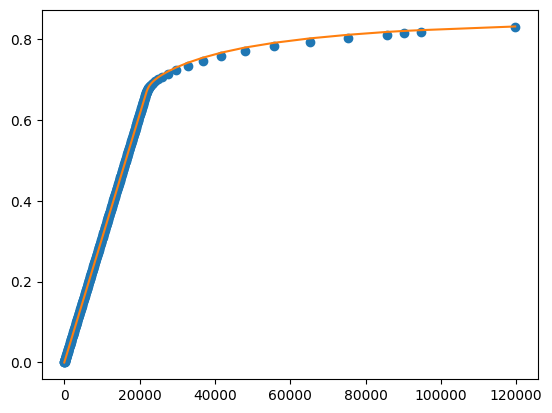

In [15]:
plt.plot(t_data, R_data, 'o')
plt.plot(t_data, R_fit, '-')

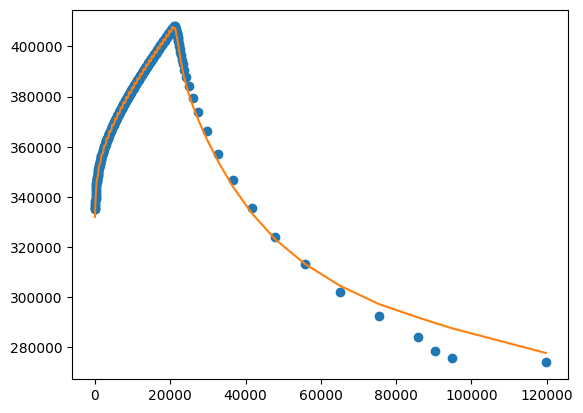

In [16]:
plt.plot(t_data, dp_data, 'o')
plt.plot(t_data, dp_fit, '-')